In [2]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [6]:
# Create our features
X = df.drop(target, axis=1)
X = pd.get_dummies(X)
# Create our target
y = df[target]

In [7]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [8]:
le = LabelEncoder()
y = y[target].apply(le.fit_transform)

In [9]:
y.head()

,loan_status
0,1
1,1
2,1
3,1
4,1


In [10]:
# Check the balance of our target values
y['loan_status'].value_counts()

1    68470
0      347
Name: loan_status, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

Counter(y_train)

Counter({'loan_status': 1})

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [12]:
# Resample the training data with the BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=1)

In [13]:
# Calculated the balanced accuracy score
y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.7877672625306695

In [14]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   58,    29],
       [ 1560, 15558]])

In [15]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.04      0.67      0.91      0.07      0.78      0.59        87
          1       1.00      0.91      0.67      0.95      0.78      0.62     17118

avg / total       0.99      0.91      0.67      0.95      0.78      0.62     17205



(0.07376667607601396, 'total_rec_prncp')
(0.06390324452717588, 'total_rec_int')
(0.06073336071656837, 'total_pymnt_inv')
(0.05811195697921674, 'total_pymnt')
(0.04951778391272079, 'last_pymnt_amnt')
(0.02458051789018817, 'int_rate')
(0.020398879691407974, 'out_prncp')
(0.018625883307901298, 'dti')
(0.018378884967316288, 'max_bal_bc')
(0.017480030880564042, 'issue_d_Jan-2019')
(0.01698703048268034, 'installment')
(0.01661321625916749, 'annual_inc')
(0.01623198470200134, 'bc_util')
(0.015821923028819504, 'mths_since_recent_inq')
(0.015385686591272854, 'total_bc_limit')
(0.015337070167127763, 'out_prncp_inv')
(0.01506649550412446, 'avg_cur_bal')
(0.014926455495755147, 'issue_d_Mar-2019')
(0.014924489307566175, 'revol_bal')
(0.014583210727445232, 'mo_sin_old_rev_tl_op')
(0.01428231366275729, 'total_bal_ex_mort')
(0.014238473969302518, 'tot_cur_bal')
(0.014067369111282934, 'mo_sin_old_il_acct')
(0.01351439379612201, 'total_bal_il')
(0.013343855077273033, 'bc_open_to_buy')
(0.013138998568932

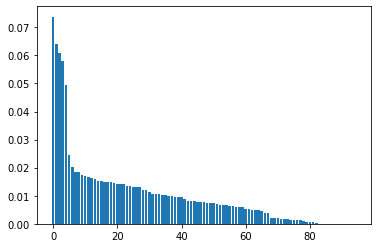

In [69]:
# List the features sorted in descending order by feature importance
features_plt = np.sort(brf.feature_importances_)[::-1]
features = list(zip(brf.feature_importances_, X.columns))
features.sort(reverse=True)
for x in features:
    print(x)
plt.bar(x = range(len(features_plt)), height=features_plt)
plt.show()

### Easy Ensemble AdaBoost Classifier

In [17]:
# Train the EasyEnsembleClassifier default is 100
eec = EasyEnsembleClassifier(random_state=1)
eec.fit(X_train, y_train)

EasyEnsembleClassifier(random_state=1)

In [18]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.9197970678173006

In [19]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   78,     9],
       [  975, 16143]])

In [20]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.07      0.90      0.94      0.14      0.92      0.84        87
          1       1.00      0.94      0.90      0.97      0.92      0.85     17118

avg / total       0.99      0.94      0.90      0.97      0.92      0.85     17205



# XGBoost

In [44]:
# Train the XGBoost
xgb = XGBClassifier(random_state=1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [45]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.9197970678173006

In [46]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   78,     9],
       [  975, 16143]])

In [47]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.07      0.90      0.94      0.14      0.92      0.84        87
          1       1.00      0.94      0.90      0.97      0.92      0.85     17118

avg / total       0.99      0.94      0.90      0.97      0.92      0.85     17205



## LightGBM

In [50]:
# Train the LightGBM
lgbm = LGBMClassifier(random_state=1)
lgbm.fit(X_train, y_train)

LGBMClassifier(random_state=1)

In [51]:
# Calculated the balanced accuracy score
y_pred = lgbm.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.7066920885859208

In [52]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   36,    51],
       [    7, 17111]])

In [53]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.41      1.00      0.55      0.64      0.39        87
          1       1.00      1.00      0.41      1.00      0.64      0.44     17118

avg / total       1.00      1.00      0.42      1.00      0.64      0.44     17205

